# Check Michael's `add_sshbdy` Pull Request

Compare results of a SalishSeaCast (green) run on `salish` to one built from
[Michael's `add_sshbdy` Pull Request](https://github.com/SalishSeaCast/NEMO-3.6-code/pull/6)
to confirm that the PR code is isolated so that we can merge the PR without affecting runs
that use the `PROD-nowcast-green-202111` tagged SalishSeaCast configuration.
The PR adds code to provide the option of imposing sea surface height at boundaries.
Susan's explanation of the PR:
> The new boundary conditions that Michael added are needed because the boundary between SalishSeaCast and SSS150 is handled differently than the boundaries of SalishSeaCast. 
> SalishSeaCast uses Flather boundary conditions to add a SSH from Neah Bay and gets two-dimensional velocities from the Flather Scheme.
> SalishSeaCast has separate tidal forcing.  SSS150 uses SSH and barotropic velocities to force the 2-D (barotropic) circulation including both tides and longer period SSH variations.

In [27]:
import sys
from pathlib import Path

import arrow
import cmocean
import matplotlib.pyplot as plt
import xarray

Python and library versions:

In [28]:
import bottleneck
import h5netcdf
import h5py
import matplotlib
import numpy
import pandas
import scipy

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")
print(f"{arrow.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'
arrow.__version__='1.3.0'


In [6]:
results_paths = {
  "baseline": Path("/data/dlatorne/MEOPAR/results/sss150/ssc_baseline/"),
  "add_sshbdy": Path("/data/dlatorne/MEOPAR/results/sss150/ssc_add_sshbdy/"),
}

In [7]:
drop_vars = {
  "nav_lat", "nav_lon",
  "bounds_nav_lat", "bounds_nav_lon",
  "time_centered", "time_centered_bounds", "time_counter_bounds", 
  "deptht_bounds", "area",
}

In [5]:
baseline_ds = xarray.open_dataset(results_paths["baseline"] / "SalishSea_1h_20240703_20240703_grid_T.nc", drop_variables=drop_vars, engine="h5netcdf")

baseline_ds

<xarray.Dataset> Size: 1GB
Dimensions:       (deptht: 40, time_counter: 6, y: 898, x: 398)
Coordinates:
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 48B 2024-07-03T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    sossheig      (time_counter, y, x) float32 9MB ...
    votemper      (time_counter, deptht, y, x) float32 343MB ...
    vosaline      (time_counter, deptht, y, x) float32 343MB ...
    sigma_theta   (time_counter, deptht, y, x) float32 343MB ...
    e3t           (time_counter, deptht, y, x) float32 343MB ...
Attributes:
    name:         SalishSea_1h_20240703_20240703_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2024-Jul-05 18:31:12 GMT
    uuid:         cbc46232-d0bd-4d63-a211-32c3fc7c361c

In [8]:
add_sshbdy_ds = xarray.open_dataset(results_paths["add_sshbdy"] / "SalishSea_1h_20240703_20240703_grid_T.nc", drop_variables=drop_vars, engine="h5netcdf")

add_sshbdy_ds

<xarray.Dataset> Size: 1GB
Dimensions:       (deptht: 40, time_counter: 6, y: 898, x: 398)
Coordinates:
  * deptht        (deptht) float32 160B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * time_counter  (time_counter) datetime64[ns] 48B 2024-07-03T00:30:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    sossheig      (time_counter, y, x) float32 9MB ...
    votemper      (time_counter, deptht, y, x) float32 343MB ...
    vosaline      (time_counter, deptht, y, x) float32 343MB ...
    sigma_theta   (time_counter, deptht, y, x) float32 343MB ...
    e3t           (time_counter, deptht, y, x) float32 343MB ...
Attributes:
    name:         SalishSea_1h_20240703_20240703_grid_T
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2024-Jul-05 23:23:03 GMT
    uuid:         157f41e8-2fd1-4ab8-ba13-fadfdfc40a66

Text(0.5, 1.0, 'difference')

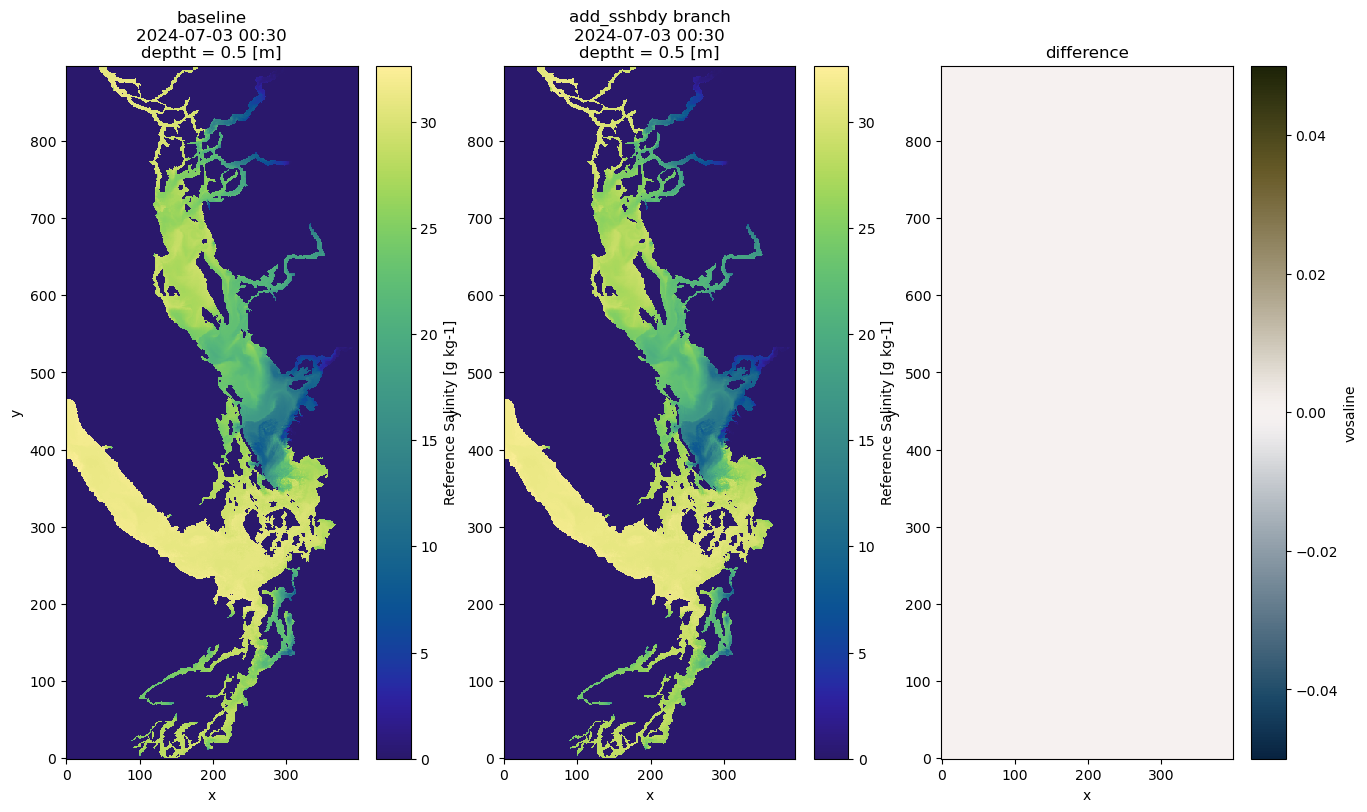

In [55]:
_, (axref, axcomp, axdiff) = plt.subplots(1, 3, figsize=(16, 9))
timestamp = arrow.get(pandas.to_datetime(baseline_ds.time_counter)[0]).format("YYYY-MM-DD HH:mm")

baseline_sal = baseline_ds.vosaline.isel(time_counter=0, deptht=0)
baseline_sal.plot(ax=axref, cmap=cmocean.cm.haline)
axref.set_title(f"baseline\n{timestamp}\n{axref.get_title().split(",")[0]}")

add_sshbdy_sal = add_sshbdy_ds.vosaline.isel(time_counter=0, deptht=0)
add_sshbdy_sal.plot(ax=axcomp, cmap=cmocean.cm.haline)
axcomp.set_title(f"add_sshbdy branch\n{timestamp}\n{axcomp.get_title().split(",")[0]}")

(baseline_sal - add_sshbdy_sal).plot(ax=axdiff, cmap=cmocean.cm.diff)
axdiff.set_title("difference")

Identical surface salinity fields indicate that the code in the PR fully isolated from the `main` branch code
and will only be activated when namelist settings do so.
This conclusion is consistent with what code review of the PR suggested would be the case.
So,
the PR will be merged into `main`.
The `SalishSeaCast_Blue/MY_SRC/` configuration directory is a symlink to the `SalishSeaCast/MY_SRC/` one.
So,
the initial `sss150` NEMO configuration(s) created based on the `SalishSeaCast_Blue` one will include the new code
to provide the option of imposing sea surface height at boundaries,
as will future configurations created based on the `SalishSeaCast` configuration. 